<a href="https://colab.research.google.com/github/Sirabhop/Kaggle_Challenges/blob/master/Challenge_1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import seaborn as sns

from pandas.api.types import CategoricalDtype
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, classification_report

import os

In [2]:
os.chdir("/content/drive/My Drive/My Project/Kaggle/Challenge#1_Titanic")

In [3]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [60]:
df['PassengerId'] = df['PassengerId'].astype('object')
#df['Survived'] = df['Survived'].astype('category') #0 is no, 1 is yes
df['Pclass'] = df['Pclass'].astype('category')
df['Pclass'].cat.reorder_categories([1, 2, 3], ordered = True)
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

In [61]:
df.drop(['Name', 'Cabin', 'Ticket'], axis = 1, inplace = True)
df.dropna(subset = ['Embarked'], axis = 0, how = 'any', inplace = True)
df['Age'].fillna(df['Age'].mean(), inplace = True)

df.reset_index(inplace = True, drop = True)

In [62]:
df.drop(['Sex'], axis = 1, inplace = True)


In [63]:
df['Embarked'].replace({'S': 'Southampton', 'C': 'Cherbourg', 'Q': 'Queenstown'}, inplace = True)
df['Pclass'].replace({1: 'First class', 2: 'Second class', 3: 'Third class'}, inplace = True)


In [ ]:
df['Survived'].replace({0: 'Death', 1: 'Survived'}, inplace = True)

The question is who gonna survive from shipwreak? from those features I can draw 3 assumption


1. **The number of sibling, children, & parent** are effected the chance of survive because the titanic passenger would do ever it take to save their relatives.
2. **The room** where passenger stayed affected too, the chance of survival may depend on how easy for them to acquire the emergency boat.
3. **The status of their ticket**, one who are VIP guest on board may thought the crew cabin would rushed out to help them instead of economics passengers.
4. **Embarkation** may determined their belongings which increase time to escape





**Passenger  ticket**
![alt text](https://drive.google.com/uc?export=view&id=1l1VjKlR4mBE1D5Gd7xEN1HPeuU1aESQC)

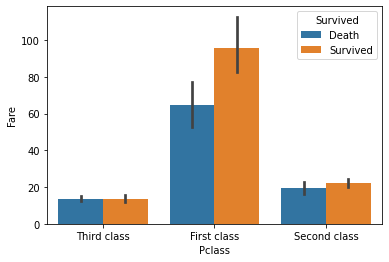

In [9]:
ax = sns.barplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = df)

![Sea lanes of Titanic](https://drive.google.com/uc?export=view&id=1DLHzbthFAdZboIGqbsKPm5utA-PB8MSL)

the route start from Southampton (UK) > Cherbourg (FR) > Queenstown (IR)


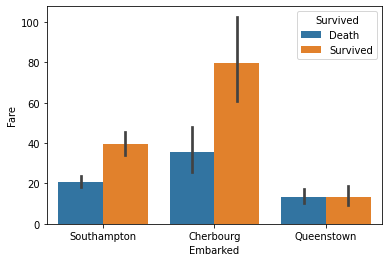

In [10]:
ax = sns.barplot(x = 'Embarked', y = 'Fare', hue = 'Survived', data = df)

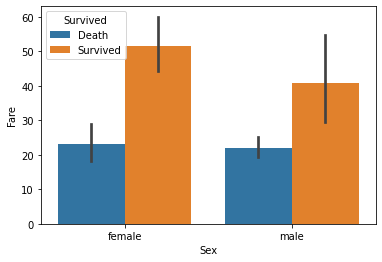

In [11]:
ax = sns.barplot(x = 'Sex',y = 'Fare', hue = 'Survived', data = df)

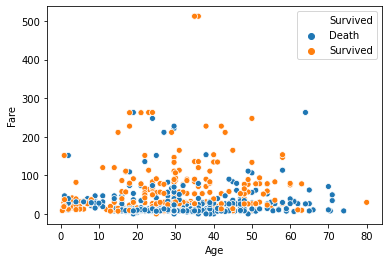

In [12]:
ax = sns.scatterplot(x = 'Age', y = 'Fare', hue = 'Survived', data = df)

In [65]:
ticket = pd.get_dummies(df['Pclass'], prefix = 'ticket')
embarked = pd.get_dummies(df['Embarked'], prefix = 'embarked')

df = pd.concat([df, ticket, embarked], axis = 1).drop(['Embarked', 'Pclass'], axis = 1)

In [34]:
df

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,ticket_First class,ticket_Second class,ticket_Third class,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton
0,1,Death,male,22.000000,1,0,7.2500,0,0,1,0,0,1
1,2,Survived,female,38.000000,1,0,71.2833,1,0,0,1,0,0
2,3,Survived,female,26.000000,0,0,7.9250,0,0,1,0,0,1
3,4,Survived,female,35.000000,1,0,53.1000,1,0,0,0,0,1
4,5,Death,male,35.000000,0,0,8.0500,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,887,Death,male,27.000000,0,0,13.0000,0,1,0,0,0,1
885,888,Survived,female,19.000000,0,0,30.0000,1,0,0,0,0,1
886,889,Death,female,29.642093,1,2,23.4500,0,0,1,0,0,1
887,890,Survived,male,26.000000,0,0,30.0000,1,0,0,1,0,0


In [38]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 2:], df.iloc[:, 1], test_size = 0.2, random_state = 0)

In [39]:
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
y_pred = classifier.predict(X_test)

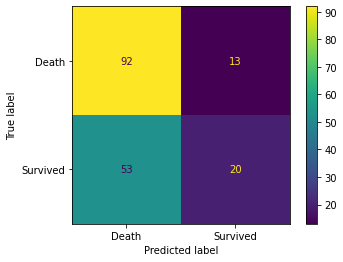

In [49]:
plot_confusion_matrix(classifier, X_test, y_test)

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Death       0.63      0.88      0.74       105
    Survived       0.61      0.27      0.38        73

    accuracy                           0.63       178
   macro avg       0.62      0.58      0.56       178
weighted avg       0.62      0.63      0.59       178



In [74]:
y_pred = classifier.predict(df)

In [69]:
df['Fare'].fillna(df['Fare'].mean(), inplace = True)

In [82]:
jay_submission_1 = pd.DataFrame(ID)

In [97]:
jay_submission_1.drop(['#Survived'], axis = 1, inplace = True)

In [95]:
jay_submission_1['Survived'] = y_pred

In [99]:
jay_submission_1.replace({'Survived':0, 'Death':1}, inplace = True)

In [101]:
jay_submission_1.to_csv('jay_submission_1.csv', index = False)

In [102]:
jay_submission_1

,PassengerId,Survived
0,892,1
1,893,1
2,894,1
3,895,1
4,896,1
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1
